In [1]:
import os.path as osp

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, GNNExplainer
import seaborn as sns

from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

from BayesianExplainer import BayesianExplainer

from tqdm import tqdm

dataset = 'Cora'
path = osp.join('data', 'Planetoid')
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 32)
        self.conv2 = GCNConv(32, 16)
        self.linear = torch.nn.Linear(16, dataset.num_features)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.linear(x)
        return F.log_softmax(x, dim=1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
x, edge_index = data.x, data.edge_index

pbar = tqdm(range(1000))
for epoch in pbar:
    model.train()
    optimizer.zero_grad()
    log_logits = model(x, edge_index)
    loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    pbar.set_description("Loss -> %.5f" % loss.item())
model.eval()

Loss -> 0.04973: 100%|██████████| 1000/1000 [00:03<00:00, 254.23it/s]


Net(
  (conv1): GCNConv(1433, 32)
  (conv2): GCNConv(32, 16)
  (linear): Linear(in_features=16, out_features=1433, bias=True)
)

Explain node 10: 100%|██████████| 200/200 [00:00<00:00, 268.33it/s]


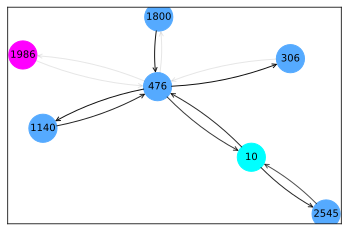

In [2]:
explainer = GNNExplainer(model, epochs=200)
node_idx = 10
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index)
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, y=data.y)
plt.show()

Loss -> 1083660518.4982: 100%|██████████| 2500/2500 [01:12<00:00, 34.55it/s]


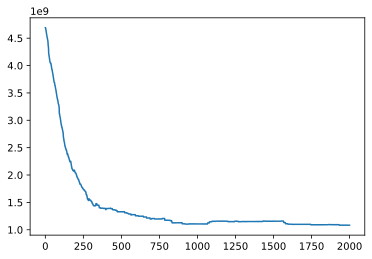

In [3]:
node_idx = 10
k = 2
sharp = 1e-6
explainer = BayesianExplainer(model, node_idx, k, x, edge_index, sharp)
avgs = explainer.train(epochs=2500, lr=0.05, window=500)
sns.lineplot(x = range(len(avgs)), y = avgs)

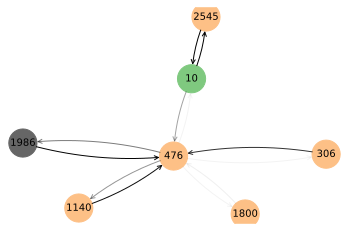

In [4]:
edge_mask = explainer.edge_mask()
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, data.y, k)
plt.show()

In [5]:
edge_mask

tensor([0.3607, 0.9985, 0.7995, 0.0191, 0.0477, 0.4126, 0.0499, 0.5136, 0.9472,
        0.0650, 0.9873, 0.9993], grad_fn=<DivBackward0>)